In [1]:
from google.colab import drive
import numpy as np
import os
import cv2
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Check if the directory is empty. If it isn't list the contents so the user can diagnose.
if os.path.exists('/content/drive') and os.listdir('/content/drive'):
  print("The /content/drive directory is not empty and contains the following files:")
  for item in os.listdir('/content/drive'):
    print(item)
else:
  # If the directory is empty or doesn't exist, proceed with mounting.
  drive.mount('/content/drive')

The /content/drive directory is not empty and contains the following files:
MyDrive
.file-revisions-by-id
.shortcut-targets-by-id
.Trash-0
.Encrypted


In [4]:
!cp "/content/drive/MyDrive/extracted_nailss.zip" "/content/"

In [5]:
!unzip -n "/content/drive/MyDrive/extracted_nailss.zip"

Archive:  /content/drive/MyDrive/extracted_nailss.zip
   creating: extracted_nailss/
  inflating: extracted_nailss/25_non_anemic_nail_2.jpg  
  inflating: extracted_nailss/125_non_anemic_nail_1.jpg  
  inflating: extracted_nailss/153_non_anemic_nail_1.jpg  
  inflating: extracted_nailss/280_anemic_nail_0.jpg  
  inflating: extracted_nailss/147_non_anemic_nail_0.jpg  
  inflating: extracted_nailss/212_non_anemic_nail_1.jpg  
  inflating: extracted_nailss/221_non_anemic_nail_0.jpg  
  inflating: extracted_nailss/19_non_anemic_nail_0.jpg  
  inflating: extracted_nailss/311_anemic_nail_2.jpg  
  inflating: extracted_nailss/249_anemic_nail_0.jpg  
  inflating: extracted_nailss/136_non_anemic_nail_0.jpg  
  inflating: extracted_nailss/128_non_anemic_nail_0.jpg  
  inflating: extracted_nailss/5_anemic_nail_1.jpg  
  inflating: extracted_nailss/82_anemic_nail_1.jpg  
  inflating: extracted_nailss/1_non_anemic_nail_0.jpg  
  inflating: extracted_nailss/100_non_anemic_nail_2.jpg  
  inflating: e

# Feature Extraction (AutoEncoder)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 0.0168 - val_loss: 0.0029
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0011 - val_loss: 6.6406e-04
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 6.3690e-04 - val_loss: 6.6714e-04
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 4.3074e-04 - val_loss: 9.5716e-04
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 4.6491e-04 - val_loss: 5.9992e-04
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 4.2250e-04 - val_loss: 2.5529e-04
Epoch 9/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 2.8352e-04 - val_loss: 2.0447e-04
Epoch 10/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 2.7168e-04 - val_loss: 7.5429e-04
Epoch 11/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 3.7437e-04 - val_loss: 1.5613e-04
Ep

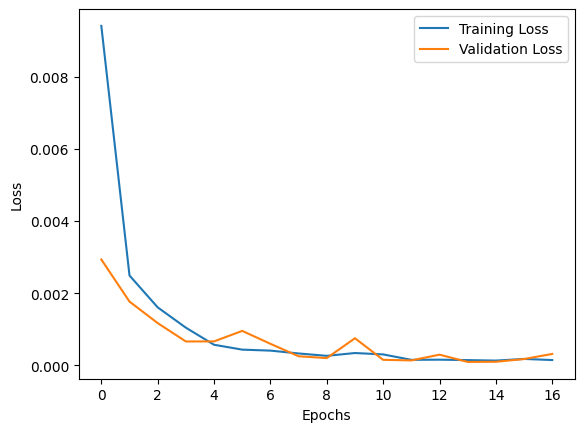

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
Extracted features shape: (750, 100352)


In [8]:
#Load and preprocess the dataset
def load_and_preprocess_images(folder_path, target_size=(224, 224)):
    images = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            # Load image
            img = cv2.imread(os.path.join(folder_path, filename))
            if img is not None:
                # Resize and normalize
                img = cv2.resize(img, target_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img.astype('float32') / 255.0
                images.append(img)

    return np.array(images)

# Load the dataset
X = load_and_preprocess_images('/content/extracted_nailss')

# Split into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

# 2. Build the autoencoder model
def build_autoencoder(input_shape=(224, 224, 3)):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Full autoencoder
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Encoder only (for feature extraction)
    encoder = Model(input_img, encoded)

    return autoencoder, encoder

autoencoder, encoder = build_autoencoder()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=30,
    batch_size=15,
    shuffle=True,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping]
    )

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Extract features using the encoder
def extract_features(encoder, images):
    features = encoder.predict(images)
    # Flatten the features to 1D vector per image
    features_flat = features.reshape((features.shape[0], -1))
    return features_flat

# Extract features for  images
all_features = extract_features(encoder, X)

print(f"Extracted features shape: {all_features.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 923ms/step


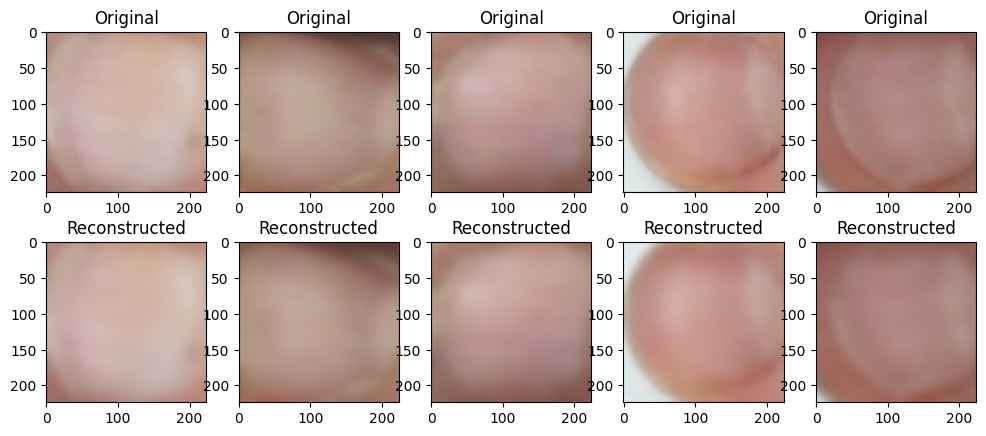

In [9]:
# Visualize some reconstructions
decoded_imgs = autoencoder.predict(X_val[:5])

plt.figure(figsize=(12,5))
for i in range(5):
    # Original
    plt.subplot(2,5,i+1)
    plt.title("Original")
    plt.imshow(X_val[i])
    # Reconstruction
    plt.subplot(2,5,i+6)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i])
plt.show()